In [1]:
import os
import json
import numpy as np
import pandas as pd

from joblib import load
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

PROJECT_ROOT = ".."  # notebooks/ → project root

CLEAN_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "accidents_india_clean.csv")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")

PREPROCESSOR_PATH = os.path.join(MODELS_DIR, "ann_preprocessor.pkl")
MODEL_PATH = os.path.join(MODELS_DIR, "ann_model.h5")
METADATA_PATH = os.path.join(MODELS_DIR, "ann_metadata.json")
LABEL_ENCODER_PATH = os.path.join(MODELS_DIR, "ann_label_encoder.pkl")


In [2]:
with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

feature_columns = metadata["feature_columns"]
class_labels = metadata["classes"]

preprocessor = load(PREPROCESSOR_PATH)
model = tf.keras.models.load_model(MODEL_PATH)

print("Feature columns:", feature_columns)
print("Classes:", class_labels)


Feature columns: ['Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Weather_conditions', 'Light_conditions', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Hour']
Classes: ['Fatal injury', 'Serious Injury', 'Slight Injury']


In [3]:
def build_input_dataframe(input_dict: dict) -> pd.DataFrame:
    """
    Build single-row DataFrame with correct column order.
    Missing keys → None (handled by preprocessor).
    """
    row = {}
    for col in feature_columns:
        row[col] = input_dict.get(col, None)
    return pd.DataFrame([row])


def compute_risk(probabilities: dict):
    """
    risk_score = P(Fatal) + P(Serious)
    Return (risk_score, risk_level: Low/Medium/High)
    """
    p_fatal = float(probabilities.get("Fatal injury", 0.0))
    p_serious = float(probabilities.get("Serious Injury", 0.0))

    risk_score = p_fatal + p_serious

    if risk_score >= 0.7:
        risk_level = "High"
    elif risk_score >= 0.4:
        risk_level = "Medium"
    else:
        risk_level = "Low"

    return risk_score, risk_level


def predict_single(input_dict: dict):
    """
    Mirror of src/inference/predict_single.predict_severity,
    but inline for notebook experiments.
    """
    df_input = build_input_dataframe(input_dict)

    X_proc = preprocessor.transform(df_input)
    if hasattr(X_proc, "toarray"):
        X_proc = X_proc.toarray()

    probs = model.predict(X_proc, verbose=0)[0]

    prob_dict = {class_labels[i]: float(probs[i]) for i in range(len(class_labels))}
    pred_idx = int(np.argmax(probs))
    pred_label = class_labels[pred_idx]

    risk_score, risk_level = compute_risk(prob_dict)

    return {
        "predicted_label": pred_label,
        "probabilities": prob_dict,
        "risk_score": risk_score,
        "risk_level": risk_level,
    }


In [4]:
test_input = {
    "Day_of_week": "Friday",
    "Age_band_of_driver": "18-30",
    "Sex_of_driver": "Male",
    "Weather_conditions": "Raining",
    "Light_conditions": "Darkness - lights lit",
    "Number_of_vehicles_involved": 3,
    "Number_of_casualties": 3,
    "Hour": 22,
}

res = predict_single(test_input)
res


{'predicted_label': 'Slight Injury',
 'probabilities': {'Fatal injury': 2.9958352465442317e-10,
  'Serious Injury': 0.491550087928772,
  'Slight Injury': 0.5084498524665833},
 'risk_score': 0.4915500882283555,
 'risk_level': 'Medium'}

In [5]:
def pretty_print_result(input_dict, result):
    print("=== INPUT ===")
    for k, v in input_dict.items():
        print(f"{k}: {v}")
    print("\n=== OUTPUT ===")
    print(f"Predicted Severity: {result['predicted_label']}")
    print(f"Risk Level: {result['risk_level']} ({result['risk_score']*100:.1f}%)")
    print("Probabilities:")
    for cls, p in result["probabilities"].items():
        print(f"  {cls}: {p*100:.2f}%")


In [6]:
test_cases = [
    {
        "name": "Low risk day-time",
        "data": {
            "Day_of_week": "Wednesday",
            "Age_band_of_driver": "31-50",
            "Sex_of_driver": "Female",
            "Weather_conditions": "Normal",
            "Light_conditions": "Daylight",
            "Number_of_vehicles_involved": 1,
            "Number_of_casualties": 0,
            "Hour": 14,
        },
    },
    {
        "name": "Night rain, multiple vehicles",
        "data": {
            "Day_of_week": "Friday",
            "Age_band_of_driver": "18-30",
            "Sex_of_driver": "Male",
            "Weather_conditions": "Raining",
            "Light_conditions": "Darkness - lights lit",
            "Number_of_vehicles_involved": 3,
            "Number_of_casualties": 3,
            "Hour": 22,
        },
    },
    {
        "name": "Severe-looking scenario",
        "data": {
            "Day_of_week": "Sunday",
            "Age_band_of_driver": "Under 18",
            "Sex_of_driver": "Male",
            "Weather_conditions": "Fog or mist",
            "Light_conditions": "Darkness - no lighting",
            "Number_of_vehicles_involved": 4,
            "Number_of_casualties": 5,
            "Hour": 2,
        },
    },
]

for case in test_cases:
    print("\n==============================")
    print(f"Case: {case['name']}")
    result = predict_single(case["data"])
    pretty_print_result(case["data"], result)



Case: Low risk day-time
=== INPUT ===
Day_of_week: Wednesday
Age_band_of_driver: 31-50
Sex_of_driver: Female
Weather_conditions: Normal
Light_conditions: Daylight
Number_of_vehicles_involved: 1
Number_of_casualties: 0
Hour: 14

=== OUTPUT ===
Predicted Severity: Serious Injury
Risk Level: Medium (61.0%)
Probabilities:
  Fatal injury: 0.00%
  Serious Injury: 60.96%
  Slight Injury: 39.04%

Case: Night rain, multiple vehicles
=== INPUT ===
Day_of_week: Friday
Age_band_of_driver: 18-30
Sex_of_driver: Male
Weather_conditions: Raining
Light_conditions: Darkness - lights lit
Number_of_vehicles_involved: 3
Number_of_casualties: 3
Hour: 22

=== OUTPUT ===
Predicted Severity: Slight Injury
Risk Level: Medium (49.2%)
Probabilities:
  Fatal injury: 0.00%
  Serious Injury: 49.16%
  Slight Injury: 50.84%

Case: Severe-looking scenario
=== INPUT ===
Day_of_week: Sunday
Age_band_of_driver: Under 18
Sex_of_driver: Male
Weather_conditions: Fog or mist
Light_conditions: Darkness - no lighting
Number_of

In [7]:
df = pd.read_csv(CLEAN_DATA_PATH)
df.head()


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_Severity,Hour
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df[feature_columns].copy()
y_text = df["Accident_Severity"]

le = LabelEncoder()
y = le.fit_transform(y_text)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test = X_test.reset_index(drop=True)
y_test_labels = le.inverse_transform(y_test)

X_test.shape, y_test.shape


((2464, 8), (2464,))

In [9]:
np.random.seed(42)
indices = np.random.choice(len(X_test), size=5, replace=False)

for idx in indices:
    row = X_test.iloc[idx].to_dict()
    true_label = y_test_labels[idx]
    result = predict_single(row)

    print("\n==============================")
    print(f"Index: {idx}")
    print(f"True label: {true_label}")
    pretty_print_result(row, result)



Index: 111
True label: Slight Injury
=== INPUT ===
Day_of_week: Tuesday
Age_band_of_driver: 31-50
Sex_of_driver: Male
Weather_conditions: Normal
Light_conditions: Daylight
Number_of_vehicles_involved: 3
Number_of_casualties: 2
Hour: 16

=== OUTPUT ===
Predicted Severity: Slight Injury
Risk Level: Low (29.1%)
Probabilities:
  Fatal injury: 0.00%
  Serious Injury: 29.06%
  Slight Injury: 70.94%

Index: 2256
True label: Slight Injury
=== INPUT ===
Day_of_week: Friday
Age_band_of_driver: 31-50
Sex_of_driver: Male
Weather_conditions: Normal
Light_conditions: Daylight
Number_of_vehicles_involved: 2
Number_of_casualties: 1
Hour: 10

=== OUTPUT ===
Predicted Severity: Serious Injury
Risk Level: Medium (51.1%)
Probabilities:
  Fatal injury: 0.00%
  Serious Injury: 51.09%
  Slight Injury: 48.91%

Index: 695
True label: Slight Injury
=== INPUT ===
Day_of_week: Monday
Age_band_of_driver: 18-30
Sex_of_driver: Male
Weather_conditions: Normal
Light_conditions: Daylight
Number_of_vehicles_involved: 2

In [10]:
risk_scores = []
risk_levels = []
pred_labels = []

for i in range(len(X_test)):
    row = X_test.iloc[i].to_dict()
    result = predict_single(row)
    risk_scores.append(result["risk_score"])
    risk_levels.append(result["risk_level"])
    pred_labels.append(result["predicted_label"])

risk_df = pd.DataFrame({
    "Risk_Score": risk_scores,
    "Risk_Level": risk_levels,
    "Predicted_Label": pred_labels,
    "True_Label": y_test_labels,
})

risk_df.head()


,Risk_Score,Risk_Level,Predicted_Label,True_Label
0,0.497615,Medium,Slight Injury,Slight Injury
1,0.339867,Low,Slight Injury,Slight Injury
2,0.234707,Low,Slight Injury,Slight Injury
3,0.445043,Medium,Slight Injury,Serious Injury
4,0.911661,High,Serious Injury,Slight Injury


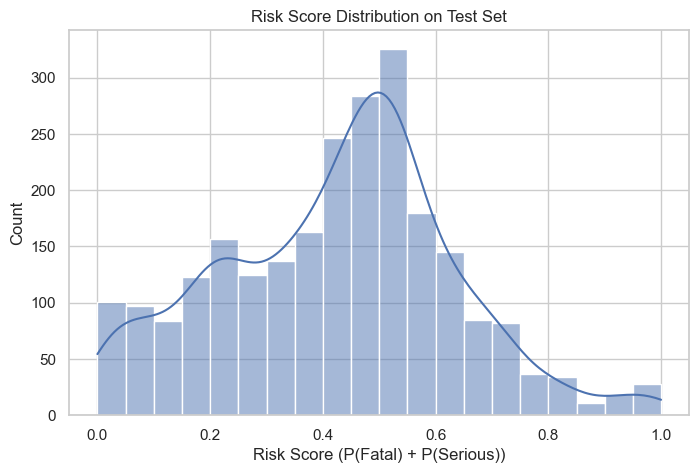

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(risk_df["Risk_Score"], bins=20, kde=True)
plt.title("Risk Score Distribution on Test Set")
plt.xlabel("Risk Score (P(Fatal) + P(Serious))")
plt.ylabel("Count")
plt.show()


In [12]:
risk_df["Risk_Level"].value_counts()


Risk_Level
Medium    1265
Low        988
High       211
Name: count, dtype: int64

In [13]:
risk_df["Risk_Level"].value_counts()


Risk_Level
Medium    1265
Low        988
High       211
Name: count, dtype: int64

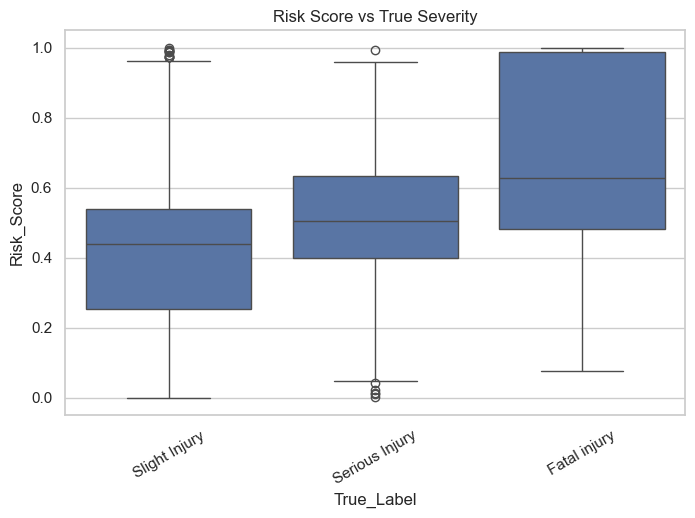

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=risk_df, x="True_Label", y="Risk_Score")
plt.title("Risk Score vs True Severity")
plt.xticks(rotation=30)
plt.show()


In [16]:
import requests

FLASK_URL = "http://127.0.0.1:5000/predict"

sample_payload = {
    "Day_of_week": "Friday",
    "Age_band_of_driver": "18-30",
    "Sex_of_driver": "Male",
    "Weather_conditions": "Raining",
    "Light_conditions": "Darkness - lights lit",
    "Number_of_vehicles_involved": 3,
    "Number_of_casualties": 3,
    "Hour": 22,
}

resp = requests.post(FLASK_URL, json=sample_payload)
resp.json()


{'predicted_label': 'Slight Injury',
 'probabilities': {'Fatal injury': 2.9958352465442317e-10,
  'Serious Injury': 0.491550087928772,
  'Slight Injury': 0.5084498524665833},
 'risk_level': 'Medium',
 'risk_score': 0.4915500882283555,
 'status': 'success'}